In [1]:
# Import relevant files, set up jax defaults, and load trajectory from file
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path
from functools import partial

# Setup Jax to use CPU - for this notebook we do not need any GPU parallelism
import jax
import jax.numpy as jnp
jax.config.update('jax_platform_name', 'cpu')
device = jax.devices("cpu")[0]
print(jax.default_backend())

from matplotlib import pyplot as plt
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica", "font.size": 14})

from Parameters import *
from PrismaticWalkerDynamicsTransformed import PrismaticWalkerTransformed, r0
import immrax as irx
import time

from scipy.linalg import sqrtm

prismatic_walker = PrismaticWalkerTransformed()
sol = jnp.load("prismatic_trajectory_y.npz")

cpu


In [2]:
# Define functions for robot dynamics
class ContSys (irx.System) :
    def __init__ (self) :
        self.xlen = 4
        self.evolution = 'continuous'
    def f (self, t, x, *args) :
        return prismatic_walker.f(t, x, *args)

cont_sys = ContSys()

phi = lambda x : jnp.array([x[0], jnp.tan(x[1]), x[2], x[3]/(jnp.cos(x[1])**2)])
phi_inv = lambda x : jnp.array([x[0], jnp.arctan(x[1]), x[2], x[3]*jnp.cos(jnp.arctan(x[1]))**2])

cont_reset = lambda x, Jds : prismatic_walker.reset(0., x, theta_H, Jds)

sys = cont_sys
reset = cont_reset


In [3]:
# Unpack Trajectory from the struct and set up interval functions for use in embedding system

xx = sol['x']
uu = sol['u']
Jds_nom = jnp.array(sol['Jds'])

x0 = jnp.asarray(xx[0])

# Set up u(t) trajectory with "extra" timetsteps to allow us to monitor the continuous dynamics after the impact (handles variation in time-to-impact)
EXTRA = 5
uu = jnp.vstack((uu, jnp.zeros((EXTRA, 1))))

LEN = len(xx)
iz = irx.icentpert(jnp.zeros(4), 0.1)

perm = irx.Permutation((0, 3, 4, 1, 2, 5))

sys_mjacM = irx.mjacM(sys.f)
izero = irx.interval(jnp.array([0.]))

Mt, Mx, Mu = sys_mjacM(izero, iz + x0, izero + 1., permutations=(perm,))[0]

Mx = irx.interval(Mx); Mu = irx.interval(Mu)

gsc = irx.utils.get_sparse_corners(Mx)
gsc_Mu = irx.utils.get_sparse_corners(Mu)

print(len(gsc(Mx)), 'sparse corners in Mx')
print(len(gsc_Mu(Mu)), 'sparse corners in Mu')


64 sparse corners in Mx
1 sparse corners in Mu


In [4]:
# Set up open-loop trajectory rollout function 
@jax.jit
def rollout_ol_sys(x0) -> jax.Array:
    def f_euler(xt, ui):
        xtp1 = xt + dt * cont_sys.f(0., xt, ui)
        return (xtp1, xtp1)
    
    _, x = jax.lax.scan(f_euler, x0, uu)
    return jnp.vstack((x0, x))

nom = rollout_ol_sys(x0)
# Test whether the rollout function works - the trajectory must be periodic, so the last point must be close to the initial point
assert np.allclose(reset(nom[LEN-1], Jds_nom) - x0, np.zeros((4,)), atol=1e-5)


In [5]:
# Backward Euler integrate the Ricatti equation along nom to get LQR gains

# Change the gains in the next line to affect the behavior of the system
# In Fig 4, we tested Q = jnp.diag(jnp.array([100., 10., 1., 1.])) and Q = jnp.diag(jnp.array([1., 1., 10., 10.]))
Q = jnp.diag(jnp.array([100., 10., 1., 1.]))

R = jnp.eye(1)*0.1

Qf = Q
P = Qf
PP = [P]

At = jax.jit(jax.jacfwd(sys.f, argnums=1))
Bt = jax.jit(jax.jacfwd(sys.f, argnums=2))

# Solve Continuous-Time Ricatti equation usiing Euler integration
K = []
for i in jnp.arange(start=len(nom)-EXTRA-2, stop=-1, step=-1):
    A = At(i*dt, nom[i], uu[i])
    B = Bt(i*dt, nom[i], uu[i])
    Pdot = -(A.T@P + P@A - (P@B)@jnp.linalg.inv(R)@(B.T@P) + Q)
    K.append(jnp.linalg.inv(R)@B.T@P)
    P -= dt*Pdot
    PP.append(P)

K = jnp.flipud(jnp.vstack(K))
PP = jnp.flipud(jnp.asarray(PP))
KK = -K

# Check to make sure solution was successful
if jnp.all(jnp.isfinite(K)) :
    print('K is finite for every t')
else :
    print('K has non-finite entries!')

# Repeat the last gain for the extra steps
KK = jnp.vstack((KK, jnp.repeat(KK[-1, :][jnp.newaxis, :], EXTRA, axis=0)))

print(KK.shape, uu.shape, nom.shape)

K is finite for every t
(65, 4) (65, 1) (66, 4)


In [6]:
# Define Rollout functions for the closed loop system and closed loop embedding system using simple Euler integration
NT = irx.L2Normotope
nt0 = NT(x0, jnp.eye(4)*1000., 1.)

@jax.jit
def rollout_cl_sys(x0) -> jax.Array:
    def f_euler(xt, args):
        x_ff, u_ff, K_ff = args

        u = u_ff + K_ff@(xt - x_ff)
        xtp1 = xt + dt * cont_sys.f(0., xt, u)

        return (xtp1, xtp1)
    
    _, x = jax.lax.scan(f_euler, x0, (nom[:-1, :], uu, KK))
    return jnp.vstack((x0, x))

# Function is called to ensure it is JIT compiled
rollout_cl_sys(nt0.ox)

@jax.jit
def rollout_cl_embsys (nt0) :
    init = nt0.vec()

    def emb_euler (state, args) :
        ui, Ki = args
        nt = NT.unvec(state)

        Ki = Ki.reshape((1, -1))

        ix = nt.iover()

        A = At(0., nt.ox, ui)
        B = Bt(0., nt.ox, ui)

        iu = irx.interval(Ki) @ (ix - nt.ox) + ui

        MM = sys_mjacM(0., ix, iu, centers=((jnp.zeros(1), nt.ox, ui),), 
                       permutations=(perm,))[0]

        Mx = MM[1]
        Mu = MM[2]

        alpha_inv = nt.alpha_inv
        
        Mx_cl = Mx + Mu @ Ki

        alpha_dot = -nt.alpha @ (A + B@Ki)
        y_dot = jnp.max(jnp.asarray([NT.mu(alpha_dot@alpha_inv + nt.alpha@M@alpha_inv) for M in gsc(Mx_cl)]))

        ox_dot = sys.f(0., nt.ox, ui).reshape(-1)
        nt_next = NT(nt.ox + dt*ox_dot, nt.alpha + dt*alpha_dot, nt.y + dt*y_dot)

        return (nt_next.vec(), nt_next.vec())

    _, state_traj = jax.lax.scan(emb_euler, init, (uu, KK))

    return jnp.vstack((nt0.vec(), state_traj))

# Function is called to ensure it is JIT compiled
tt = jnp.arange(0., dt*(len(uu)+1), dt)
nt_traj = rollout_cl_embsys(nt0)
print(len(nt_traj), len(tt))


66 66


In [7]:
# Computing Kds using the closed-loop system and nominal trajectory
from diffrax import ODETerm, Euler, Event, diffeqsolve, backward_hermite_coefficients, CubicInterpolation
import optimistix as optx
from scipy.signal import place_poles

t_nom = jnp.arange(0., dt*(len(sol['u'])+1), dt)
xnom_coeffs = backward_hermite_coefficients(t_nom, sol['x'])
xnom_interp = CubicInterpolation(t_nom, xnom_coeffs)
theta_vs_t = jax.vmap(xnom_interp.evaluate)(t_nom.flatten())[:, 1]

u_coeffs = backward_hermite_coefficients(t_nom[:-1], sol['u'])
u_interp = CubicInterpolation(t_nom[:-1], u_coeffs)
K_coeffs = backward_hermite_coefficients(t_nom[:-1], K)
K_interp = CubicInterpolation(t_nom[:-1], K_coeffs)

# Function to check guard intersection with a diffrax-compatible function signature
foot_height = lambda t, y, args, **kwargs: prismatic_walker.foot_height(0, y, theta_H)

# Function to roll out closed loop dynamics with a diffrax-compatible function signature
def cl_f(t, x, args):
    phase = t

    u_ff = u_interp.evaluate(phase)
    x_ff = xnom_interp.evaluate(phase)
    K_ff = K_interp.evaluate(phase)
    u = u_ff - K_ff[np.newaxis, :]@(x - x_ff)
    # u = u_ff 
    return prismatic_walker.f(t, x, u)

# Rolls out one step from one guard surface intersection to the next guard surface intersection (including reset and continuous dynamics)
# This function uses diffrax to integrate until an event condition is reached (namely that the foot hits the guard surface)
def one_step(xminus, Jds):
    xreset = prismatic_walker.reset(0, xminus, theta_H, Jds)
    term = ODETerm(cl_f)
    solver = Euler()
    root_finder = optx.Newton(1e-5, 1e-5, optx.rms_norm)
    event = Event(foot_height, root_finder)
    sol = diffeqsolve(term, solver, t0, tf*2, y0=xreset, dt0=dt, event=event)
    return sol.ys[0]

# Test one_step for nominal trajectory
x0_center = sol['x'][-1].reshape(-1)
assert np.allclose(x0_center, one_step(x0_center, sol['Jds']))


# Compute approximate linearization by flowing 4 initial conditions near the nominal trajectory
# forward by 1 step, and comparing the initial and final points
perturbation = 1e-3

guard_surface_grad = jax.grad(lambda y: foot_height(0, y, None))(x0_center)
guard_surface_chart = jnp.vstack([irx.utils.null_space(guard_surface_grad[jnp.newaxis, :]).T])
x0s = [x0_center + perturbation*guard_surface_chart[i, :] for i in range(3)]
x0s.append(x0_center - perturbation*guard_surface_grad)
x0s = jnp.vstack(x0s)

x1s = jax.vmap(partial(one_step, Jds=sol['Jds']))(x0s)
xk0 = x0s - x0_center
xk1 = x1s - x0_center
Ad = xk1.T@np.linalg.inv(xk0.T)
Bd = (one_step(sol['x'][-1, :], sol['Jds'] + perturbation) - one_step(sol['x'][-1, :], sol['Jds']))/perturbation
Bd = Bd[:, np.newaxis]
eigs = np.array([0, 0.1, 0.2, 0.3])
K_Jds = -place_poles(Ad, Bd, eigs).gain_matrix
# print(repr(K_Jds))

print(np.linalg.eigvals(Ad+Bd@K_Jds))
assert np.allclose(eigs, np.sort_complex(np.linalg.eigvals(Ad+Bd@K_Jds)), atol=1e-5)

[-5.9604645e-08+0.j  3.0000097e-01+0.j  9.9999696e-02+0.j
  2.0000008e-01+0.j]


In [8]:
# Test closed-loop step to step control
one_step_cl = lambda x: one_step(x, sol['Jds'] + K_Jds @ (x - x0_center))


x1s_cl = jax.vmap(one_step_cl)(x0s)

xk1 = x1s_cl - x0_center
A_cl = xk1.T@np.linalg.inv(xk0.T)

assert np.allclose(eigs, np.sort_complex(np.linalg.eigvals(A_cl)), atol=1e-1)
# If we made it past this then we know the eigenvalues of the linearization of the map from x-_k to x-_k+1 is stable and our pole placement strategy worked.

In [9]:
# Get P matrix for step-to-step map (map from x+_k to x+_k+1)

# Define function for step-to-step map
def one_step_cl_plus(xplus):
    term = ODETerm(cl_f)
    solver = Euler()
    root_finder = optx.Newton(1e-5, 1e-5, optx.rms_norm)
    event = Event(foot_height, root_finder)
    traj = diffeqsolve(term, solver, t0, tf*2, y0=xplus, dt0=dt, event=event)
    xminus = traj.ys[0]
    xreset = prismatic_walker.reset(0, xminus, theta_H, sol['Jds'] + K_Jds @ (xminus - x0_center))
    return xreset

start_time = time.perf_counter()

x0_plus_center = sol['x'][0, :]
x0s_plus = [x0_plus_center + perturbation*np.eye(4)[i, :] for i in range(4)]
x0s_plus = jnp.vstack(x0s_plus)

x1s_plus = jax.vmap(one_step_cl_plus)(x0s_plus)

# This is the approximate linearization of the step-to-step dynamics
A_cl_plus = (x1s_plus - x0_plus_center).T@np.linalg.inv((x0s_plus - x0_plus_center).T)


compute_A_cl_time = time.perf_counter() - start_time

assert np.allclose(x0_plus_center, one_step_cl_plus(x0_plus_center))
assert np.all(np.abs(np.linalg.eigvals(A_cl_plus)) < 1)
# If we made it this far we know A_cl_plus is stable


In [10]:
# Define and compile function to check ellipsoid passing through reset map

start_time = time.perf_counter()

g_lf_a = jnp.array([-1./(r0*jnp.sin(theta_H)), 1., 0., 0.])
g_lf_b = -1./jnp.tan(theta_H)
norm = jnp.linalg.norm(g_lf_a)
g_lf_a = g_lf_a / norm
g_lf_b = g_lf_b / norm

null_space = irx.utils.null_space(g_lf_a[None,:])
null_space_p = jnp.linalg.pinv(null_space)
T_guard_basis = jnp.hstack((g_lf_a[:,None], null_space))
T_guard_basis_p = jnp.linalg.pinv(T_guard_basis)

# Sparse extraction for M_reset
test_cl_reset = lambda x : reset(x, Jds_nom + K_Jds @ (x - NT.unvec(nt_traj[LEN-1]).ox))
test_basis_reset = lambda x : test_cl_reset(null_space @ x)
test_mjac_basis_reset = irx.mjacM(test_basis_reset)
test_M_reset = test_mjac_basis_reset(irx.icentpert(jnp.zeros(3), 1.), permutations=(irx.Permutation((1,2,0)),))[0][0]
M_reset_gsc = irx.utils.get_sparse_corners(test_M_reset)


def alpha0_to_lengths (alpha0) :
    _nt0 = NT(x0, alpha0, 1.)
    _nt_traj = rollout_cl_embsys(_nt0)

    _nt_pre = NT.unvec(_nt_traj[LEN-1])

    _basis_nt_pre = NT(T_guard_basis_p@_nt_pre.ox, _nt_pre.alpha @ T_guard_basis, _nt_pre.y)

    # _a = jax.scipy.linalg.sqrtm((_basis_nt_pre.alpha.T @ _basis_nt_pre.alpha)[1:,1:])
    _a = jnp.linalg.qr(_basis_nt_pre.alpha[:,1:])[1]

    _basis_nt_pre_slice = NT(_basis_nt_pre.ox[1:], _a, _basis_nt_pre.y)
    _slice_samples = _basis_nt_pre_slice.sample_boundary(jax.random.PRNGKey(123), 1000)

    _guard_xs = (null_space @ (_slice_samples - _basis_nt_pre_slice.ox).T).T + _nt_pre.ox

    cl_reset = lambda x : reset(x, Jds_nom + K_Jds @ (x - _nt_pre.ox))
    _post_guard_xs = jax.vmap(cl_reset)(_guard_xs)
    _post_guard_lengths = jax.vmap(_nt0.g)(_post_guard_xs)

    return _post_guard_lengths



def alpha0_to_mjac_lengths (alpha0) :
    _nt0 = NT(x0, alpha0, 1.)
    _nt_traj = rollout_cl_embsys(_nt0)

    _nt_pre = NT.unvec(_nt_traj[LEN-1])

    _basis_nt_pre = NT(T_guard_basis_p@_nt_pre.ox, _nt_pre.alpha @ T_guard_basis, _nt_pre.y)

    _a = jnp.linalg.qr(_basis_nt_pre.alpha[:,1:])[1]

    _basis_nt_pre_slice = NT(_basis_nt_pre.ox[1:], _a, _basis_nt_pre.y)
    _basis_iover = _basis_nt_pre_slice.iover()

    _cl_reset = lambda x : reset(x, Jds_nom + K_Jds @ (x - _nt_pre.ox))

    _basis_reset = lambda x : _cl_reset(null_space @ (x - _basis_nt_pre_slice.ox) + _nt_pre.ox)

    _mjac_basis_reset = irx.mjacM(_basis_reset)
    _M_reset = _mjac_basis_reset(_basis_iover, centers=((_basis_nt_pre_slice.ox,),), permutations=(irx.Permutation((1,2,0)),))[0][0]

    sparse_Ms = M_reset_gsc(_M_reset)

    return jnp.array([NT.induced_norm(alpha0 @ M @ _basis_nt_pre_slice.alpha_inv*_basis_nt_pre_slice.y) for M in sparse_Ms])


@jax.jit
def alpha0_to_max_mjac_length (alpha0) :
    lengths = alpha0_to_mjac_lengths(alpha0)
    return jnp.max(lengths)

@jax.jit
def cost (alpha0, l) :
    # post_lengths = alpha0_to_lengths(alpha0)
    post_lengths = alpha0_to_mjac_lengths(alpha0)
    L = jnp.linalg.cholesky(alpha0.T @ alpha0)
    vol = -jnp.sum(jnp.log(jnp.diag(L)))
    # return jnp.mean(post_lengths) + l*vol, jnp.max(post_lengths)
    return jnp.max(post_lengths) + l*vol, jnp.max(post_lengths)

grad_cost = jax.jit(jax.value_and_grad(cost, has_aux=True))

alpha = nt0.alpha

# print('Starting JIT compile...', end=' ')

# cost(alpha, 1.)
# grad_cost(alpha, 1.)
alpha0_to_max_mjac_length(alpha)

jit_time = time.perf_counter() - start_time
# print('Finished.')


In [11]:
# Contraction-based procedure to compute initial alpha set

import cvxpy as cp
from scipy.linalg import sqrtm

start_time = time.perf_counter()
# Contraction rate is the spectral radius of A
c = jnp.max(jnp.abs(jnp.linalg.eigvals(A_cl_plus))) + 1e-4
# print(c)
P_cp = cp.Variable(A_cl_plus.shape, symmetric=True)
cons = []
cons.append(A_cl_plus.T @ P_cp @ A_cl_plus << c**2*P_cp)
cons.append(P_cp >> jnp.eye(A_cl_plus.shape[0]))
prob = cp.Problem(cp.Minimize(cp.trace(P_cp)), cons)
prob.solve()

P_plus = P_cp.value
alpha = sqrtm(P_plus)
compute_P_time = time.perf_counter() - start_time

print('P = ', P_plus)
print('alpha = ', alpha)


P =  [[ 2.50920421e+03  3.14187770e+03 -5.92697093e+01  5.75022247e+02]
 [ 3.14187770e+03  3.98565065e+03 -7.37821413e+01  7.27526982e+02]
 [-5.92697093e+01 -7.37821413e+01  2.44455549e+00 -1.34881907e+01]
 [ 5.75022247e+02  7.27526982e+02 -1.34881907e+01  1.33919825e+02]]
alpha =  [[33.48847141 36.60907579 -0.80660103  6.84481223]
 [36.60907579 50.64227215 -0.8315003   8.94958656]
 [-0.80660103 -0.8315003   1.04025372 -0.14293257]
 [ 6.84481223  8.94958656 -0.14293257  2.63682409]]


/home/varun/miniconda3/envs/immrax/lib/python3.12/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [12]:
# Rescaling alpha while maintaining invariance

from scipy.optimize import bisect

# print(best_cost, best_alpha)
start_time = time.perf_counter()
best_alpha = sqrtm(P_plus.copy())*100
gamma = 0.99

root_fun = lambda s : alpha0_to_max_mjac_length(best_alpha / s) - gamma

scaling, r = bisect(root_fun, 1., 10., xtol=1e-3, full_output=True)

alpha = best_alpha / scaling
cost = alpha0_to_max_mjac_length(alpha)
optimize_time = time.perf_counter() - start_time
print(f'scaled alpha0 by {scaling:<.2f}')
print(cost, alpha)
print("Elapsed optimization time: ", optimize_time)
print("Total Time: ", compute_A_cl_time + compute_P_time + optimize_time)
print("JIT Time: ", jit_time)
print("Time With JIT: ", jit_time + compute_A_cl_time + compute_P_time + optimize_time)
print(r)

scaled alpha0 by 8.92
0.99004936 [[375.45256549 410.43890169  -9.04312481  76.73991087]
 [410.43890169 567.7706446   -9.32228037 100.33737263]
 [ -9.04312481  -9.32228037  11.66269799  -1.60247383]
 [ 76.73991087 100.33737263  -1.60247383  29.56248303]]
Elapsed optimization time:  0.5612117580021732
Total Time:  1.006921597989276
JIT Time:  5.58476898400113
Time With JIT:  6.591690581990406
      converged: True
           flag: converged
 function_calls: 16
     iterations: 14
           root: 8.91949462890625
         method: bisect


mc_trajs shape (50, 66, 4)
mean cost in mc 0.00047717473


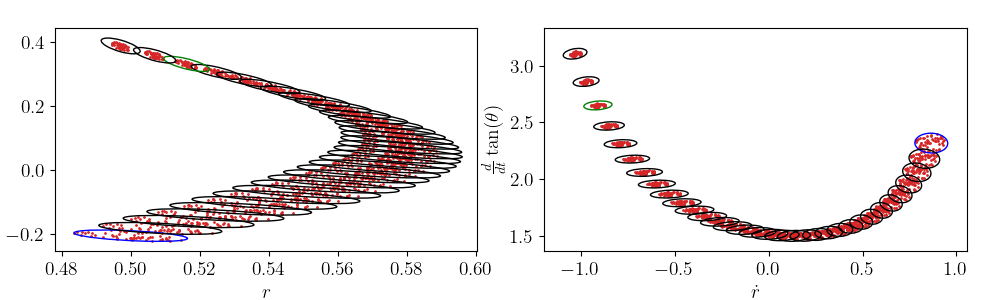

In [13]:
# Plotting the normotope trajectory aka the reachable tube
%matplotlib widget

nt0 = NT(x0, alpha, 1.)

nt_traj = rollout_cl_embsys(nt0)

PLOT_EVERY = 2

fig, axs = plt.subplots(1, 2, figsize=(10,3))

mc_x0s = nt0.sample_boundary(jax.random.PRNGKey(21), 50)
# mc_x0s = mc_x0s.at[:,0].set(r0)
# mc_x0s = jnp.vstack((mc_x0s, x0 + 1e-5*jnp.array([ 0., -0.43590355, 1.9377115, 1.8873239])))
mc_trajs = jax.vmap(rollout_cl_sys)(mc_x0s)
print('mc_trajs shape', mc_trajs.shape)

def mc_cost (xf) :
    return jnp.sum((xf - nom[-1])**2)

print('mean cost in mc', jnp.mean(jax.vmap(mc_cost)(mc_trajs[:,-1,:])))

indices = [(0,1), (2,3)]

labels = [r'$r$', r'$\tan(\theta)$', r'$\dot{r}$', r'$\frac{d}{dt} \tan(\theta)$']

fig.tight_layout()

for ax, ind in zip(axs, indices) :
    ax.plot(nom[:, ind[0]], nom[:, ind[1]], color='k', lw=.01, alpha=0.05)
    ax.scatter(mc_trajs[:, ::PLOT_EVERY, ind[0]], mc_trajs[:, ::PLOT_EVERY, ind[1]], color='tab:red', s=1)
    ax.set_xlabel(labels[ind[0]])
    ax.set_ylabel(labels[ind[1]])

for i in range(0,len(nt_traj),PLOT_EVERY) :
    try :
        for ax, ind in zip(axs, indices) :
            nt = NT.unvec(nt_traj[i])
            # color = 'k' if i != 0 else 'b'
            if i == 0:
                color = 'b'
            elif i == LEN-1:
                color = 'g'
            else:
                color = 'k'
            nt.plot_projection(ax, ind[0], ind[1], color=color)
    except :
        pass


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


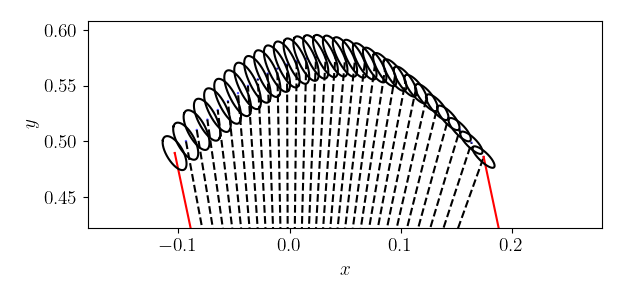

In [14]:
# Plotting the walker with reachable tube transformed to x-y coordinates
# Generates Fig 4 from paper
# Change the Q matrix in Cell 5 and re-run the notebook to generate the second plot in Fig 4

from matplotlib import patches

def plot_solution(fig, x_sol, plt_args='k'):
    circle_rad = 0.0005
    x0_sol = x_sol[0, :]
    r, th, rd, thd = x0_sol
    # Initial Position
    leg_line = np.array([[0, 0], 
                         [r*np.sin(th), r*np.cos(th)]])
    plt.plot(leg_line[:, 0], leg_line[:, 1], 'r')
    circle = patches.Circle((r*np.sin(th), r*np.cos(th)), circle_rad, color='red', alpha=0.6)
    fig.get_axes()[0].add_patch(circle)
    initial_torso = np.array([r*np.sin(th), r*np.cos(th)])
    leg_initial = leg_line

    # Stance Leg Trajectory
    for i in range(1, x_sol.shape[0]):
        r, th, rd, thd = x_sol[i, :]
        leg_line = np.array([[0, 0], 
                            [r*np.sin(th), r*np.cos(th)]])
        plt.plot(leg_line[:, 0], leg_line[:, 1], plt_args+'--')
        circle = patches.Circle((r*np.sin(th), r*np.cos(th)), circle_rad, color='blue', alpha=0.6)
        fig.get_axes()[0].add_patch(circle)

    r, th, rd, thd = x_sol[-1, :]
    # Final state/New initial state
    torso_offset = np.array([r*np.sin(th), r*np.cos(th)]) - initial_torso
    leg_line = torso_offset + leg_initial
    plt.plot(leg_line[:, 0], leg_line[:, 1], 'r')
    circle = patches.Circle((r*np.sin(th), r*np.cos(th)), circle_rad, color='red', alpha=0.6)
    fig.get_axes()[0].add_patch(circle)
    plt.axis('equal')

def draw_nti (ax, nt) :
    tt = jnp.linspace(0., 2*jnp.pi, 500)
    Pi = nt.alpha.T @ nt.alpha; yi = nt.y**2
    Qi = irx.Ellipsoid.get_projection_mtx(Pi/yi)
    # r-th ellipsoid is x^T Qi x = 1, solving for r
    # Q11 r^2 + 2 Q12 r th + Q22 th^2 = 1, define parametric curve
    L, V = jnp.linalg.eigh(Qi)
    rr, tanth = V @ ((1/jnp.sqrt(L))[:,None] * jnp.vstack((jnp.cos(tt), jnp.sin(tt))))
    thth = jnp.atan(tanth)
    # print(ellipse.shape)
    nom = phi(nt.ox)
    xx = (rr + nom[0]) * jnp.sin(thth + nom[1])
    yy = (rr + nom[0]) * jnp.cos(thth + nom[1])
    # xx = (rr) * jnp.sin(thth + nt.ox[1])
    # yy = (rr) * jnp.cos(thth + nt.ox[1])
    nomxy = jnp.array([nom[0] * jnp.sin(nom[1]), nom[0] * jnp.cos(nom[1])])
    ax.plot(xx, yy, 'k-')

def plot_nt_traj(ax, nt_traj, plt_args='k--'):
    for i in range(0,len(nt_traj),2):
        nt = NT.unvec(nt_traj[i])
        draw_nti(ax, nt)
    

fig = plt.figure()
fig.set_figheight(3.0)
# fig.set_figheight(2.5)
ax = plt.axes()

x_sol = jax.vmap(phi)(sol['x'])[::2, ...]

plot_solution(fig, x_sol)
# draw_nti(fig.get_axes()[0], NT.unvec(nt_traj[0]))
plot_nt_traj(ax, nt_traj[:LEN])
# plt.title("Hip Trajectory with Reachable Tube")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim([-0.15, 0.25])
plt.ylim([0.45, 0.58])
plt.tight_layout()

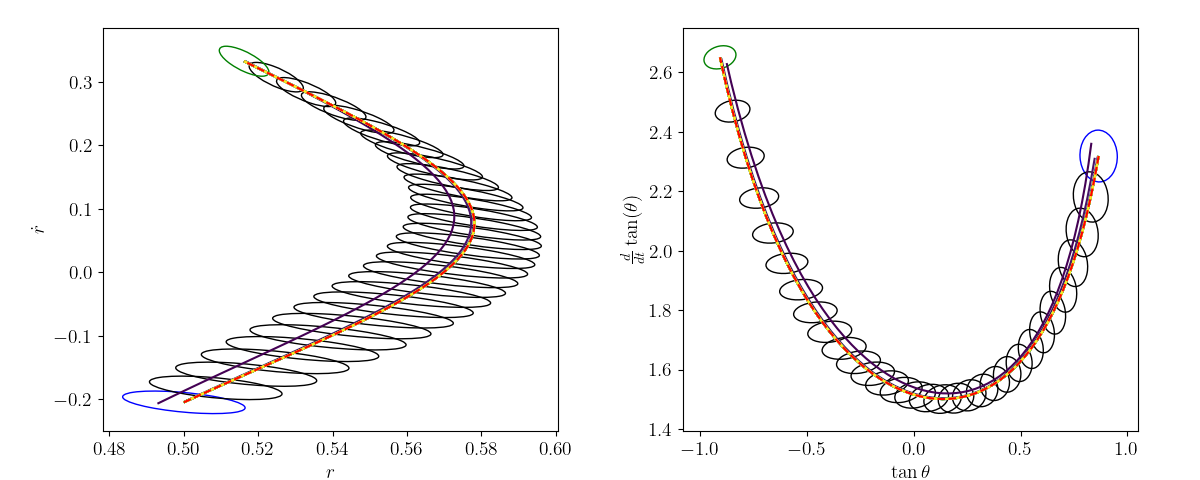

In [15]:
# Monte Carlo Simulation of single trajectory on nt0 boundary - empirically check that tube is invariant
# Generates Fig 3 from paper

from diffrax import SaveAt
from matplotlib.collections import LineCollection

def rollout_cl_sys_to_guard(x0):
    term = ODETerm(cl_f)
    solver = Euler()
    saveat = SaveAt(t0=True, t1=True, steps=True)
    root_finder = optx.Newton(1e-5, 1e-5, optx.rms_norm)
    event = Event(foot_height, root_finder)
    sol = diffeqsolve(term, solver, t0, tf*2, y0=x0, dt0=dt, saveat=saveat, event=event)
    return sol

x0 = nt0.sample_boundary(jax.random.PRNGKey(2), 1).flatten()
ys = []
ts = []
xfs = []
gs = []
tintermediate = 0

steps = 20

for i in range(steps):
    gs.append(nt0.g(x0))
    step_sol = rollout_cl_sys_to_guard(x0)
    ts.append(step_sol.ts[np.isfinite(step_sol.ts)] + tintermediate)
    ys.append(step_sol.ys[np.isfinite(step_sol.ts)])
    xf = ys[-1][-1, :]
    tf = ts[-1][-1]
    xfs.append(xf)
    tintermediate = tf
    if(step_sol.event_mask == False):
        print(f"Did Not Hit Guard after {i} steps!")
        break
    delta_Jds = K_Jds@(xf-x0_center)
    x0 = prismatic_walker.reset(tf, xf, theta_H, np.max(np.array([np.array([0]), sol['Jds'] + delta_Jds])))

rth = [[(ys[i][j, 0], ys[i][j, 1]) for j in range(len(ts[i]))] for i in range(len(ts))]
lc_0 = LineCollection(rth, array = np.linspace(0.0, 1.0, len(ts)), cmap=plt.get_cmap('viridis'))

rrd = [[(ys[i][j, 2], ys[i][j, 3]) for j in range(len(ts[i]))] for i in range(len(ts))]
lc_1 = LineCollection(rrd, array = np.linspace(0.0, 1.0, len(ts)), cmap=plt.get_cmap('viridis'))

# rth = [[(ts[i][j], ys[i][j, 0]) for j in range(len(ts[i]))] for i in range(len(ts))]
# lc_2 = LineCollection(rth, array = np.linspace(0.0, 1.0, len(ts)), cmap=plt.get_cmap('viridis'))

ththd = [[(ys[i][j, 1], ys[i][j, 3]) for j in range(len(ts[i]))] for i in range(len(ts))]
lc_2 = LineCollection(ththd, array = np.linspace(0.0, 1.0, len(ts)), cmap=plt.get_cmap('viridis'))

xf_arr = [(xfs[i][0], xfs[i][1]) for i in range(len(ts))]

ts = jnp.hstack(ts)
ys = jnp.vstack(ys)
fig, axs_mc = plt.subplots(1, 2)
fig.tight_layout()
axs_mc[0].add_collection(lc_0)
axs_mc[0].autoscale(enable=True)
axs_mc[0].plot(sol['x'][:, 0], sol['x'][:, 1], 'r--')
axs_mc[0].set_xlabel("$r$")
axs_mc[0].set_ylabel("$\\dot{r}$")

axs_mc[1].add_collection(lc_1)
axs_mc[1].autoscale(enable=True)
axs_mc[1].plot(sol['x'][:, 2], sol['x'][:, 3], 'r--')
axs_mc[1].autoscale(enable=True)
axs_mc[1].set_xlabel("$\\tan\\theta$")
axs_mc[1].set_ylabel(r'$\frac{d}{dt} \tan(\theta)$')


for i in range(0,LEN,PLOT_EVERY) :
    try :
        for ax, ind in zip(axs_mc, indices) :
            nt = NT.unvec(nt_traj[i])
            # color = 'k' if i != 0 else 'b'
            if i == 0:
                color = 'b'
            elif i == LEN-1:
                color = 'g'
            else:
                color = 'k'
            nt.plot_projection(ax, ind[0], ind[1], color=color)
    except :
        pass

fig.set_figwidth(12)
plt.savefig("monte_carlo.pdf")
plt.show()
# plt.close()


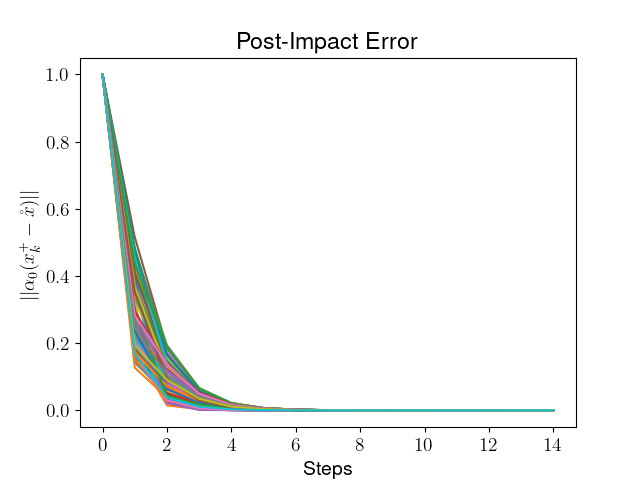

In [16]:
# Decay of many points over large number of steps

mc_x0s = nt0.sample_boundary(jax.random.PRNGKey(21), 100)

xs = [mc_x0s]
alphas = []
steps = 15
for i in range(steps):
    alphas.append(jax.vmap(nt0.g)(xs[-1]))
    xs.append(jax.vmap(one_step_cl_plus)(xs[-1]))

fig_steps = plt.figure()
plt.plot(alphas)
plt.xlabel("Steps")
plt.ylabel("$||\\alpha_0(x^+_k - \\mathring{x})||$")
plt.title("Post-Impact Error")
plt.savefig("alpha_0.pdf")
